# N05A - Fully Supervised Training with Parameterised Signals using High-Level Features

## Step 1: Data Loading

- Data is stored in the form of TFRecord files that can be loaded lazily into tensorflow dataset

In [1]:
import os
import glob
import json

import numpy as np
import tensorflow as tf

from aliad.interface.tensorflow.dataset import (apply_pipelines, split_dataset,
                                                get_ndarray_tfrecord_example_parser)

dirname = '/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled'
filenames = glob.glob(os.path.join(dirname, '*.tfrec'))
# sort by the shard index
filenames = sorted(filenames, key = lambda f: int(os.path.splitext(f)[0].split("_")[-1]))
metadata_filenames = glob.glob(os.path.join(dirname, '*metadata.json'))

# metadata contains information about the shape and dtype of each type of features, as well as the size of the dataset
metadata = json.load(open(metadata_filenames[-1]))

2023-12-06 19:29:56.886902: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
filenames

['/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled/SR_point_cloud_train_features_shuffled_shard_0.tfrec',
 '/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled/SR_point_cloud_train_features_shuffled_shard_1.tfrec',
 '/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled/SR_point_cloud_train_features_shuffled_shard_2.tfrec',
 '/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled/SR_point_cloud_train_features_shuffled_shard_3.tfrec',
 '/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled/SR_point_cloud_train_features_shuffled_shard_4.tfrec',
 '/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled/SR_point_cloud_train_features_shuffled_shard_5.tfrec',
 '/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics

In [3]:
metadata['features']

{'event_number': {'shape': [1], 'dtype': 'int64'},
 'jet_features': {'shape': [2, 7], 'dtype': 'float64'},
 'label': {'shape': [1], 'dtype': 'int64'},
 'param_masses_ordered': {'shape': [2], 'dtype': 'float64'},
 'param_masses_unordered': {'shape': [2], 'dtype': 'float64'},
 'part_coords': {'shape': [2, 300, 2], 'dtype': 'float64'},
 'part_features': {'shape': [2, 300, 4], 'dtype': 'float64'},
 'part_masks': {'shape': [2, 300], 'dtype': 'bool'},
 'weight': {'shape': [1], 'dtype': 'float64'},
 'weight_merged': {'shape': [1], 'dtype': 'float64'}}

In [4]:
# method for parsing the binary tfrecord into array data
parse_tfrecord_fn = get_ndarray_tfrecord_example_parser(metadata['features'])

# method to extract the feature vectors and label from the tfrecord
def get_input_fn(high_level:bool=True, mass_ordering:str=False, weighted:bool=True):
    if high_level:
        if mass_ordering:
            if weighted:
                return lambda X: ((X['jet_features'], X['param_masses_ordered']), X['label'], X['weight'][0])
            else:
                return lambda X: ((X['jet_features'], X['param_masses_ordered']), X['label'])
        else:
            if weighted:
                return lambda X: ((X['jet_features'], X['param_masses_unordered']), X['label'], X['weight'][0])
            else:
                return lambda X: ((X['jet_features'], X['param_masses_unordered']), X['label'])
    else:
        raise RuntimeError('not implemented')

def get_dataset(filenames, batch_size:int, input_fn):
    ds = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.AUTOTUNE)
    ds = ds.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(input_fn, num_parallel_calls=tf.data.AUTOTUNE)
    # datasets pre-shuffled, no need to shuffle again
    ds = apply_pipelines(ds, batch_size=batch_size,
                         shuffle=False, prefetch=True)
    return ds

batch_size = 1024
input_fn = get_input_fn(high_level=True, mass_ordering=False, weighted=False)
# each file contains 100k events and are pre-shuffled, so we just use diferent set of files for train, validation and test
ds_train = get_dataset(filenames[:50], batch_size=batch_size, input_fn=input_fn)
ds_val   = get_dataset(filenames[50:75], batch_size=batch_size, input_fn=input_fn)
ds_test  = get_dataset(filenames[75:100], batch_size=batch_size, input_fn=input_fn)

2023-12-06 19:30:02.140354: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38219 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


## Step 2: Create simple MLP model

In [5]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Flatten
x1 = Input(**metadata['features']['jet_features'])
x2 = Input(**metadata['features']['param_masses_ordered'])
x2 = tf.reshape(x2, [-1, 2, 1])
x  = tf.concat([x1, x2], -1)
shape = tf.shape(x)
x = tf.reshape(x, (-1, tf.reduce_prod(shape[1:])))
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=[x1, x2], outputs=x, name='HighLevel')

In [6]:
config = {
    # for binary classification
    'loss'       : 'binary_crossentropy',
    'metrics'    : ['accuracy'],
    'epochs'     : 100,
    'optimizer'  : 'Adam',
    'optimizer_config': {
        'learning_rate': 0.001
    },
    'checkpoint_dir': '/pscratch/sd/c/chlcheng/model_checkpoints/LHCO_AD/fully_supervised/'
                      'param_high_level_10M_events_SR_unordered_unweighted_v1',
    'callbacks': {
        'lr_scheduler': {
            'initial_lr': 0.001,
            'lr_decay_factor': 0.5,
            'patience': 5,
            'min_lr': 1e-6
        },
        'early_stopping': {
            'monitor': 'val_loss',
            'patience': 3
        },
        'model_checkpoint':{
            'save_weights_only': True,
            # save model checkpoint every epoch
            'save_freq': 'epoch'
        },
        'metrics_logger':{
            'save_freq': -1
        }
    }
}

In [7]:
optimizer = tf.keras.optimizers.get({'class_name': config['optimizer'], 'config': config['optimizer_config']})
model.compile(loss=config['loss'],
              optimizer=optimizer,
              metrics=config['metrics'])

### Prepare callbacks

In [8]:
from aliad.interface.tensorflow.callbacks import LearningRateScheduler, MetricsLogger
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_dir = config['checkpoint_dir']
import os
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

lr_scheduler = LearningRateScheduler(**config['callbacks']['lr_scheduler'])

early_stopping = EarlyStopping(**config['callbacks']['early_stopping'])

checkpoint = ModelCheckpoint(os.path.join(checkpoint_dir, 'model_weights_epoch_{epoch:02d}.h5'),
                             **config['callbacks']['model_checkpoint'])
metrics_logger = MetricsLogger(checkpoint_dir, **config['callbacks']['metrics_logger'])
callbacks = [lr_scheduler, early_stopping, checkpoint, metrics_logger]

In [9]:
model.summary()

Model: "HighLevel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 7)]       0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 2, 1)]       0           []                               
                                                                                                  
 tf.concat (TFOpLambda)         (None, 2, 8)         0           ['input_1[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 tf.compat.v1.shape (TFOpLambda  (3,)                0           ['tf.concat[1][0]']      

## Step 3: Train Model

In [10]:
model.fit(ds_train,
          validation_data=ds_val,
          epochs=config['epochs'],
          callbacks=callbacks)

Epoch 1/100


2023-12-06 17:53:14.533932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [50]
	 [[{{node Placeholder/_0}}]]
2023-12-06 17:53:14.534185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [50]
	 [[{{node Placeholder/_0}}]]


      9/Unknown - 4s 18ms/step - loss: 5.2900 - accuracy: 0.7929

2023-12-06 17:53:18.466466: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


   4880/Unknown - 160s 32ms/step - loss: 0.1658 - accuracy: 0.9520

2023-12-06 17:55:56.219259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [25]
	 [[{{node Placeholder/_0}}]]
2023-12-06 17:55:56.219534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [25]
	 [[{{node Placeholder/_0}}]]


4882/4882 [==============================] - 250s 50ms/step - loss: 0.1658 - accuracy: 0.9520 - val_loss: 0.1002 - val_accuracy: 0.9641
Epoch 2/100
4882/4882 [==============================] - 263s 54ms/step - loss: 0.0966 - accuracy: 0.9649 - val_loss: 0.0896 - val_accuracy: 0.9676
Epoch 3/100
4882/4882 [==============================] - 261s 54ms/step - loss: 0.0865 - accuracy: 0.9685 - val_loss: 0.0786 - val_accuracy: 0.9717
Epoch 4/100
4882/4882 [==============================] - 249s 51ms/step - loss: 0.0798 - accuracy: 0.9710 - val_loss: 0.0786 - val_accuracy: 0.9716
Epoch 5/100
4882/4882 [==============================] - 248s 51ms/step - loss: 0.0764 - accuracy: 0.9721 - val_loss: 0.0748 - val_accuracy: 0.9729
Epoch 6/100
4882/4882 [==============================] - 251s 51ms/step - loss: 0.0742 - accuracy: 0.9728 - val_loss: 0.0779 - val_accuracy: 0.9714
Epoch 7/100
4882/4882 [==============================] - 236s 48ms/step - loss: 0.0724 - accuracy: 0.9734 - val_loss: 0.0778

In [11]:
# save entire model
filename = os.path.join(config['checkpoint_dir'], "full_train.keras")
model.save(filename)

## Step 4 - Model Testing

In [10]:
filename = os.path.join(config['checkpoint_dir'], "full_train_20_epoch.keras")
model = tf.keras.models.load_model(filename)

### Prediction on the full dataset (25% of 10M events, mixed signals)

In [12]:
import numpy as np
predicted_proba = model.predict(ds_test).flatten()
y_pred = np.round(predicted_proba)
y_true = np.array([y for (x, y) in ds_test]).flatten()

      6/Unknown - 5s 12ms/step

2023-11-24 17:50:47.753992: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2441/2441 [==============================] - 39s 14ms/step


In [39]:
def get_mass_points(filenames, base_parse_func, batch_size):
    ds = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.AUTOTUNE)
    ds = ds.map(base_parse_func, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(lambda x: [x['m1'][0], x['m2'][0]])
    ds = apply_pipelines(ds, batch_size=batch_size,
                         shuffle=False, prefetch=True)
    return ds

ds_test_masses = get_mass_points(filenames[75:100], parse_tfrecord_fn, batch_size=batch_size)

mass_points = np.array([d for d in ds_test_masses])

In [58]:
mass_points_  =np.transpose(mass_points, axes=(0, 2, 1))
mass_points_ = mass_points_.reshape((np.product(mass_points_.shape[:-1]), mass_points_.shape[-1]))
m1 = mass_points_[:, 0]
m2 = mass_points_[:, 1]

In [61]:
predicted_results = {
    'predicted_proba': predicted_proba,
    'y_pred': y_pred,
    'y_true': y_true,
    'm1': m1,
    'm2': m2
}
import pandas as pd
df = pd.DataFrame(predicted_results)

In [65]:
filename = os.path.join(config['checkpoint_dir'], "prediction.parquet")
df.to_parquet(filename, engine='fastparquet')

### Create ROC curves

In [12]:
config['checkpoint_dir']

'/pscratch/sd/c/chlcheng/model_checkpoints/LHCO_AD/fully_supervised/param_high_level_10M_events_SR_v1'

In [8]:
import os
import pandas as pd
filename = os.path.join(config['checkpoint_dir'], "prediction.parquet")
df = pd.read_parquet(filename)

In [9]:
from sklearn.metrics import accuracy_score, roc_auc_score, auc, roc_curve
from scipy.interpolate import interp1d
epsilon = 1e-4

def get_bootstrap_prediction(y_prob, y_true, num_bootstrap_samples:int=20,
                             seed:int=2023):
    np.random.seed(seed)
    bootstrap_y_prob = []
    bootstrap_y_true = []
    sample_size = y_prob.shape[0]
    for _ in range(num_bootstrap_samples):
        # Sampling with replacement
        indices = np.random.choice(sample_size, sample_size, replace=True)
        y_prob_i = y_prob[indices]
        y_true_i = y_true[indices]
        bootstrap_y_prob.append(y_prob_i)
        bootstrap_y_true.append(y_true_i)
    bootstrap_y_prob = np.array(bootstrap_y_prob)
    bootstrap_y_true = np.array(bootstrap_y_true)
    return bootstrap_y_prob, bootstrap_y_true

def compute_median_and_variance_roc_sic(tprs_list, fprs_list, resolution=1000, mean=False):

    # interpolation
    max_min_tpr = 0.
    min_max_tpr = 1.
    for tpr in tprs_list:
        if min(tpr) > max_min_tpr:
            max_min_tpr = min(tpr)
        if max(tpr) < min_max_tpr:
            min_max_tpr = max(tpr)
    tpr_manual = np.linspace(max_min_tpr, min_max_tpr, resolution)

    roc_interpol = []
    sic_interpol = []
    for tpr, fpr in zip(tprs_list, fprs_list):
        roc_function = interp1d(tpr, 1/(fpr+epsilon))
        sic_function = interp1d(tpr, tpr/((fpr+epsilon)**(0.5)))
        roc_interpol.append(roc_function(tpr_manual))
        sic_interpol.append(sic_function(tpr_manual))
                     
    # calculating mean+std or median+quantiles
    if mean:
        roc_median = np.mean(np.stack(roc_interpol), axis=0)
        sic_median = np.mean(np.stack(sic_interpol), axis=0)
        roc_std = np.std(np.stack(roc_interpol), axis=0)
        sic_std = np.std(np.stack(sic_interpol), axis=0)
        roc_std = (roc_median-roc_std, roc_median+roc_std)
        sic_std = (sic_median-sic_std, sic_median+sic_std)
    else:
        roc_median = np.median(np.stack(roc_interpol), axis=0)
        sic_median = np.median(np.stack(sic_interpol), axis=0)
        roc_std = (np.quantile(np.stack(roc_interpol), 0.16, axis=0), np.quantile(np.stack(roc_interpol), 0.84, axis=0))
        sic_std = (np.quantile(np.stack(sic_interpol), 0.16, axis=0), np.quantile(np.stack(sic_interpol), 0.84, axis=0))
    
    return tpr_manual, roc_median, sic_median, roc_std, sic_std

def get_roc_curve_data(y_prob, y_true, num_bootstrap_samples:int=20, seed:int=2023):
    bootstrap_y_prob, bootstrap_y_true = get_bootstrap_prediction(y_prob,
                                                                  y_true,
                                                                  num_bootstrap_samples=num_bootstrap_samples,
                                                                  seed=2023)
    bootstrap_fpr, bootstrap_tpr= [], []
    for i in range(num_bootstrap_samples):
        bs_fpr, bs_tpr, _ = roc_curve(bootstrap_y_true[i], bootstrap_y_prob[i])
        bootstrap_fpr.append(bs_fpr)
        bootstrap_tpr.append(bs_tpr)
    tpr_manual, roc_median, _, roc_std, _ = compute_median_and_variance_roc_sic(bootstrap_tpr,
                                                                                bootstrap_fpr)
    result = {
        'tpr': tpr_manual,
        'fpr_inv': roc_median,
        'errlo': roc_std[0],
        'errhi': roc_std[1]
    }
    return result

In [10]:
num_bootstrap_samples = 100
seed = 2023
mass_points = ['inclusive', '500_100', '100_500', '150_150', '200_300']
dfs = {}
aucs = {}
for mass_point in mass_points:
    df_m = df
    if mass_point != 'inclusive':
        m1, m2 = mass_point.split("_")
        df_m = df_m.query(f'((m1 == {m1}) & (m2 == {m2})) or '
                          f'((m1 == 0) & (m2 == 0))')
    y_prob = df_m['predicted_proba'].values
    y_true = df_m['y_true'].values
    data = get_roc_curve_data(y_prob, y_true, num_bootstrap_samples, seed=seed)
    dfs[mass_point] = pd.DataFrame(data).query(f'fpr_inv < {1/epsilon}')
    aucs[mass_point] = auc(1/data['fpr_inv'], data['tpr'])

<Figure size 640x480 with 0 Axes>

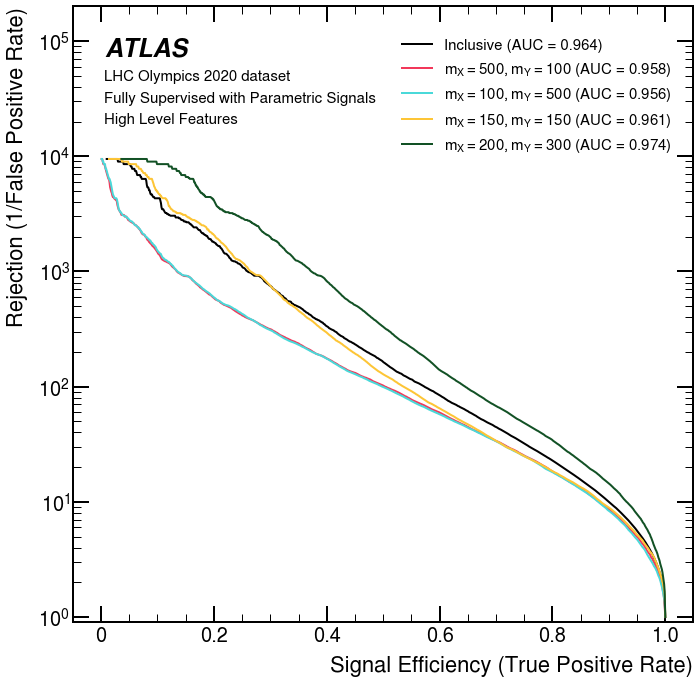

In [11]:
from quickstats.plots import General1DPlot
analysis_label_options = {
    'colab': 'ATLAS',
    'status': '', 
    'energy' : None, 
    'lumi' : None,
    'dy': 0.03,
    'dy_main': 0,
    'loc': (0.05, 0.95),
    'extra_text': f'LHC Olympics 2020 dataset//Fully Supervised with Parametric Signals//High Level Features'
}
styles = {
    'figure': {
        'figsize': (11.111, 11.111),
    },
    'legend': {
        'loc': (0.52, 0.75),
        'fontsize': 15
    },
    'text': {
        'fontsize': 15
    }
}
label_map = {}
for mass_point in mass_points:
    roc_auc = aucs[mass_point]
    if mass_point == 'inclusive':
        label = f'Inclusive'
    else:
        m1, m2 = mass_point.split("_")
        label = f'$m_X={m1}, m_Y={m2}$'
    label += f' (AUC = {roc_auc:.3f})'
    label_map[mass_point] = label    
plotter = General1DPlot(dfs, analysis_label_options=analysis_label_options, color_cycle='default', styles=styles, label_map=label_map)    
ax = plotter.draw("tpr", "fpr_inv",
                  logy=True,
                  xlabel="Signal Efficiency (True Positive Rate)",
                  ylabel="Rejection (1/False Positive Rate)",
                  ymax=2e5,
                  ymin=0.9)
#ax.fill_between(tpr_manual, roc_std[0], roc_std[1], color='rust', alpha=0.3)

### Evaluate test metrics

The accuracy does not reflect the fact that most of the events are signals and the background accuracy is actually not good.

In [66]:
accuracy = np.mean(y_true == y_pred)
accuracy

0.9620976930561246

In [67]:
from sklearn.metrics import accuracy_score, roc_auc_score, auc, roc_curve
fpr, tpr, _ = roc_curve(y_true, predicted_proba.flatten())
roc_auc = auc(fpr, tpr)
roc_auc

0.9644887456338762

In [25]:
from quickstats.utils.common_utils import NpEncoder
import numpy as np
import json
results = {
    'predicted_proba': predicted_proba,
    'y_pred': y_pred,
    'y_true': y_true,
    'accuracy': accuracy,
    'auc': roc_auc,
    'tpr': tpr,
    'fpr': fpr,
    #'bootstrap_predicted_proba': bootstrap_predictions,
    #'bootstrap_y_true': bootstrap_truths,
    #'bootstrap_y_pred': bootstrap_y_pred,
    #'bootstrap_tpr': bootstrap_tpr,
    #'bootstrap_fpr': bootstrap_fpr,
    'bootstrap_accuracy': bootstrap_accuracy,
    'bootstrap_auc': bootstrap_auc,
    'tpr_manual': tpr_manual,
    'roc_median': roc_median,
    'roc_std': roc_std
}
filename = os.path.join(config['checkpoint_dir'], "test_results.json")
json.dump(results, open(filename, "w"), cls=NpEncoder)

In [26]:
import json
import pandas as pd
filename = os.path.join(config['checkpoint_dir'], "metrics_history.json")
metrics_history = json.load(open(filename))
num_epochs = 13
dfs = {}
for key, value in metrics_history.items():
    dfs[key] = pd.DataFrame(value)
    steps_per_epoch = dfs[key].shape[0] // num_epochs
    dfs[key]['epoch'] = (dfs[key].index + 1) / steps_per_epoch

In [27]:
from quickstats.plots import General1DPlot
label_map = {
    'train': 'Train',
    'val': 'Validation'
}
analysis_label_options = {
    'colab': 'ATLAS',
    'status': '', 
    'energy' : None, 
    'lumi' : None,
    'loc': (0.1, 0.9),
    'extra_text': 'LHC Olympics 2020 dataset//Parametric Fully Supervised with High Level Features'
}
styles = {
    'legend': {
        'loc': (0.7, 0.8)
    }
}
plotter = General1DPlot(dfs, color_cycle='checker',
                        label_map=label_map, styles=styles,
                        analysis_label_options=analysis_label_options)

<Axes: xlabel='Epoch', ylabel='Loss'>

<Figure size 640x480 with 0 Axes>

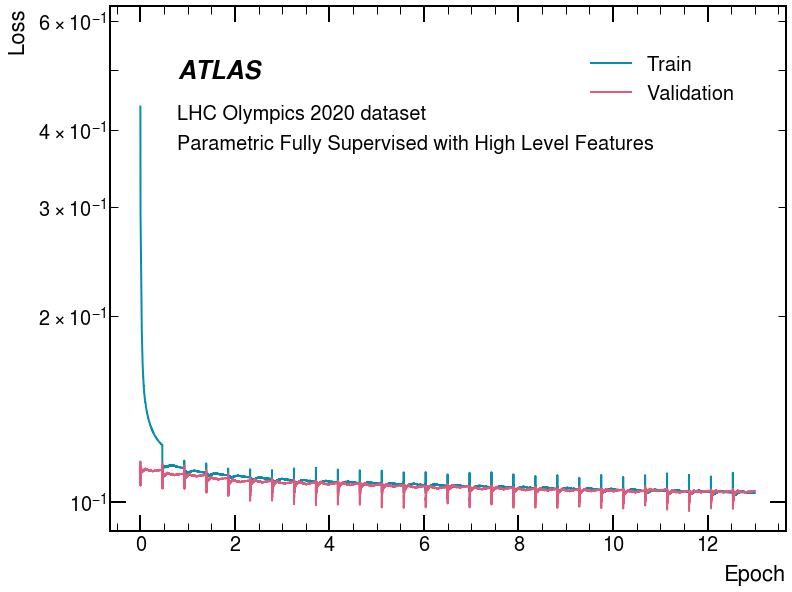

In [28]:
plotter.draw('epoch', 'loss', logy=True, xlabel='Epoch', ylabel='Loss')

<Axes: xlabel='Epoch', ylabel='Accuracy'>

<Figure size 640x480 with 0 Axes>

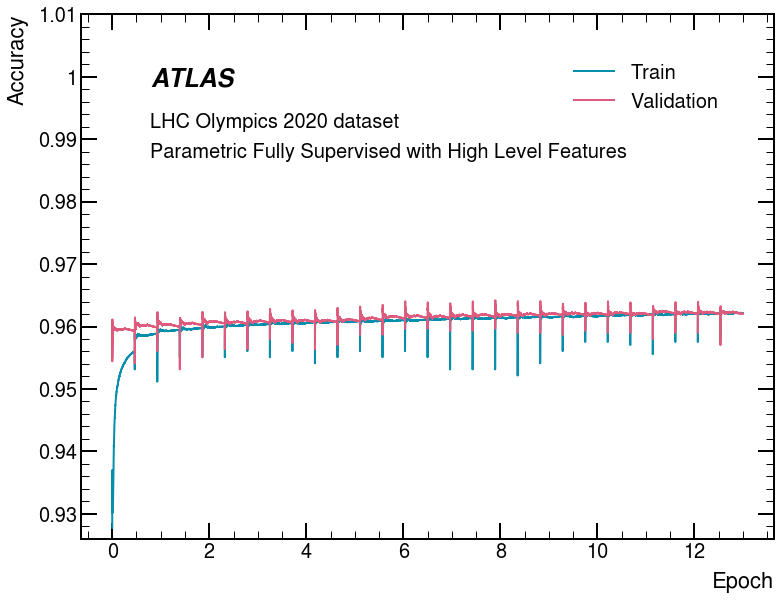

In [29]:
plotter.draw('epoch', 'accuracy', xlabel='Epoch', ylabel='Accuracy', ymax=1.01)

In [30]:
sig_mask = y_true == 1
bkg_mask = y_true == 0
dfs = {
    'Signal'     : pd.DataFrame({"score": predicted_proba.flatten()[sig_mask]}),
    'Background' : pd.DataFrame({"score": predicted_proba.flatten()[bkg_mask]})
}

In [31]:
from quickstats.plots import VariableDistributionPlot
analysis_label_options = {
    'colab': 'ATLAS',
    'status': '', 
    'energy' : None, 
    'lumi' : None,
    'loc': (0.12, 0.9),
    'extra_text': 'LHC Olympics 2020 dataset//Fully Supervised with Low Level Features'
}
styles = {
    'legend': {
        'loc': (0.65, 0.8)
    }
}
plotter = VariableDistributionPlot(dfs, color_cycle='checker',
                                   styles=styles, analysis_label_options=analysis_label_options)

<Axes: xlabel='Predicted Prob.', ylabel='Fraction of Events / 0.04'>

<Figure size 640x480 with 0 Axes>

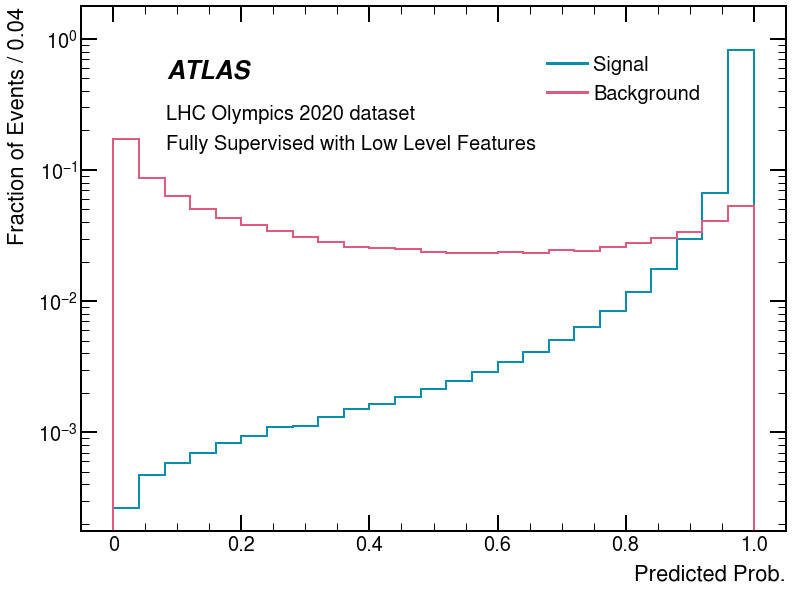

In [32]:
plotter.draw('score', xlabel='Predicted Prob.', bin_range=(0, 1), logy=True)

# Multi-Scenarios Check

In [5]:
import os
import json
import numpy as np
import pandas as pd
scenarios = ["mass_ordered_unweighted",
             "mass_ordered_weighted",
             "mass_unordered_unweighted",
             "mass_unordered_weighted"]
checkpoint_dir = "/pscratch/sd/c/chlcheng/model_checkpoints/LHCO_AD/fully_supervised/"
scenario_dfs = {}
for scenario in scenarios:
    filename = os.path.join(checkpoint_dir, f"param_high_level_10M_events_SR_{scenario}_v2", "test_results.json")
    data = json.load(open(filename))
    for key in data:
        data[key] = np.array(data[key])
    scenario_dfs[scenario] = pd.DataFrame(data)

In [9]:
from sklearn.metrics import accuracy_score, roc_auc_score, auc, roc_curve
from scipy.interpolate import interp1d
epsilon = 1e-4

def get_bootstrap_prediction(y_prob, y_true, num_bootstrap_samples:int=20,
                             seed:int=2023):
    np.random.seed(seed)
    bootstrap_y_prob = []
    bootstrap_y_true = []
    sample_size = y_prob.shape[0]
    for _ in range(num_bootstrap_samples):
        # Sampling with replacement
        indices = np.random.choice(sample_size, sample_size, replace=True)
        y_prob_i = y_prob[indices]
        y_true_i = y_true[indices]
        bootstrap_y_prob.append(y_prob_i)
        bootstrap_y_true.append(y_true_i)
    bootstrap_y_prob = np.array(bootstrap_y_prob)
    bootstrap_y_true = np.array(bootstrap_y_true)
    return bootstrap_y_prob, bootstrap_y_true

def compute_median_and_variance_roc_sic(tprs_list, fprs_list, resolution=1000, mean=False):

    # interpolation
    max_min_tpr = 0.
    min_max_tpr = 1.
    for tpr in tprs_list:
        if min(tpr) > max_min_tpr:
            max_min_tpr = min(tpr)
        if max(tpr) < min_max_tpr:
            min_max_tpr = max(tpr)
    tpr_manual = np.linspace(max_min_tpr, min_max_tpr, resolution)

    roc_interpol = []
    sic_interpol = []
    for tpr, fpr in zip(tprs_list, fprs_list):
        roc_function = interp1d(tpr, 1/(fpr+epsilon))
        sic_function = interp1d(tpr, tpr/((fpr+epsilon)**(0.5)))
        roc_interpol.append(roc_function(tpr_manual))
        sic_interpol.append(sic_function(tpr_manual))
                     
    # calculating mean+std or median+quantiles
    if mean:
        roc_median = np.mean(np.stack(roc_interpol), axis=0)
        sic_median = np.mean(np.stack(sic_interpol), axis=0)
        roc_std = np.std(np.stack(roc_interpol), axis=0)
        sic_std = np.std(np.stack(sic_interpol), axis=0)
        roc_std = (roc_median-roc_std, roc_median+roc_std)
        sic_std = (sic_median-sic_std, sic_median+sic_std)
    else:
        roc_median = np.median(np.stack(roc_interpol), axis=0)
        sic_median = np.median(np.stack(sic_interpol), axis=0)
        roc_std = (np.quantile(np.stack(roc_interpol), 0.16, axis=0), np.quantile(np.stack(roc_interpol), 0.84, axis=0))
        sic_std = (np.quantile(np.stack(sic_interpol), 0.16, axis=0), np.quantile(np.stack(sic_interpol), 0.84, axis=0))
    
    return tpr_manual, roc_median, sic_median, roc_std, sic_std

def get_roc_curve_data(y_prob, y_true, num_bootstrap_samples:int=20, seed:int=2023):
    bootstrap_y_prob, bootstrap_y_true = get_bootstrap_prediction(y_prob,
                                                                  y_true,
                                                                  num_bootstrap_samples=num_bootstrap_samples,
                                                                  seed=2023)
    bootstrap_fpr, bootstrap_tpr= [], []
    for i in range(num_bootstrap_samples):
        bs_fpr, bs_tpr, _ = roc_curve(bootstrap_y_true[i], bootstrap_y_prob[i])
        bootstrap_fpr.append(bs_fpr)
        bootstrap_tpr.append(bs_tpr)
    tpr_manual, roc_median, _, roc_std, _ = compute_median_and_variance_roc_sic(bootstrap_tpr,
                                                                                bootstrap_fpr)
    result = {
        'tpr': tpr_manual,
        'fpr_inv': roc_median,
        'errlo': roc_std[0],
        'errhi': roc_std[1]
    }
    return result

In [27]:
num_bootstrap_samples = 100
seed = 2023
mass_points = ['inclusive', '600_50', '50_600', '150_150']
target_mass_dfs = {}
aucs = {}
for scenario in scenarios:
    print(f'INFO: Working on scneario "{scenario}"')
    aucs[scenario] = {}
    target_mass_dfs[scenario] = {}
    scenario_df = scenario_dfs[scenario]
    for mass_point in mass_points:
        print(f'INFO: Working on mass point "{mass_point}"')
        df_m = scenario_df
        if mass_point != 'inclusive':
            m1, m2 = [float(m) for m in mass_point.split("_")]
            if (m2 > m1) and 'mass_ordered' in scenario:
                continue
            # only filter by signal mass
            sig_mask = (df_m['y_true'] == 1) & (df_m['m1'] == m1) & (df_m['m2'] == m2)
            bkg_mask = (df_m['y_true'] == 0)
            df_m = df_m[sig_mask | bkg_mask]
        y_prob = df_m['predicted_proba'].values
        y_true = df_m['y_true'].values
        data = get_roc_curve_data(y_prob, y_true, num_bootstrap_samples, seed=seed)
        target_mass_dfs[scenario][mass_point] = pd.DataFrame(data).query(f'fpr_inv < {1/epsilon}')
        aucs[scenario][mass_point] = auc(1/data['fpr_inv'], data['tpr'])

INFO: Working on scneario "mass_ordered_unweighted"
INFO: Working on mass point "inclusive"
INFO: Working on mass point "600_50"
INFO: Working on mass point "50_600"
INFO: Working on mass point "150_150"
INFO: Working on scneario "mass_ordered_weighted"
INFO: Working on mass point "inclusive"
INFO: Working on mass point "600_50"
INFO: Working on mass point "50_600"
INFO: Working on mass point "150_150"
INFO: Working on scneario "mass_unordered_unweighted"
INFO: Working on mass point "inclusive"
INFO: Working on mass point "600_50"
INFO: Working on mass point "50_600"
INFO: Working on mass point "150_150"
INFO: Working on scneario "mass_unordered_weighted"
INFO: Working on mass point "inclusive"
INFO: Working on mass point "600_50"
INFO: Working on mass point "50_600"
INFO: Working on mass point "150_150"


<Figure size 640x480 with 0 Axes>

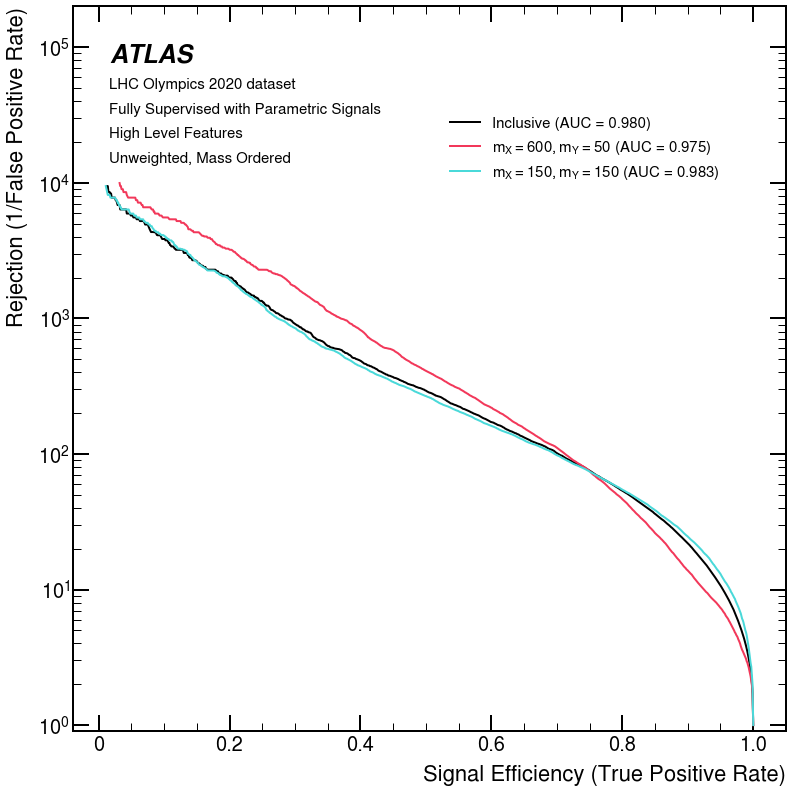

<Figure size 640x480 with 0 Axes>

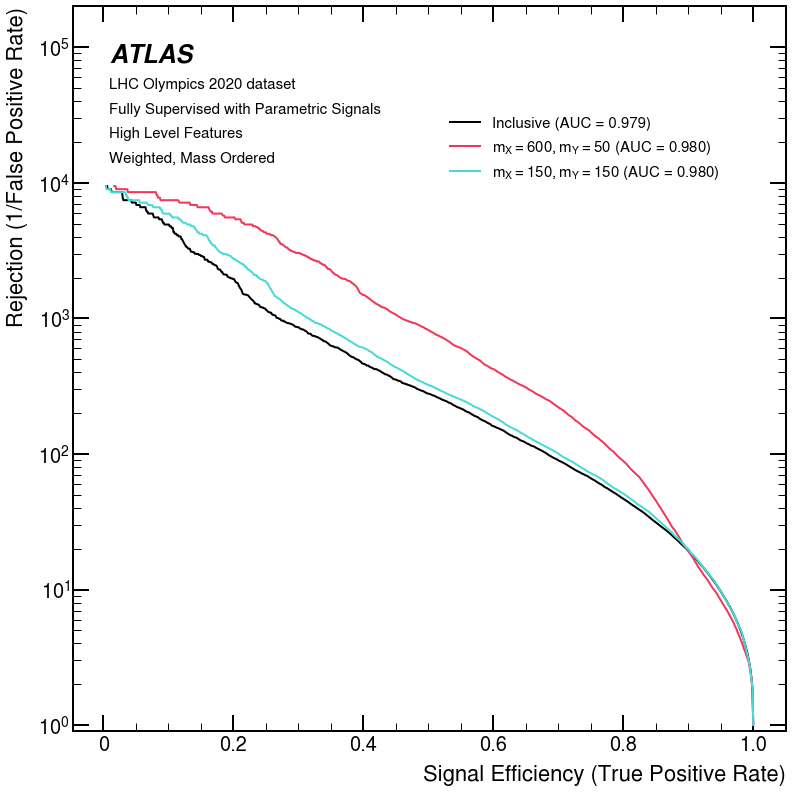

<Figure size 640x480 with 0 Axes>

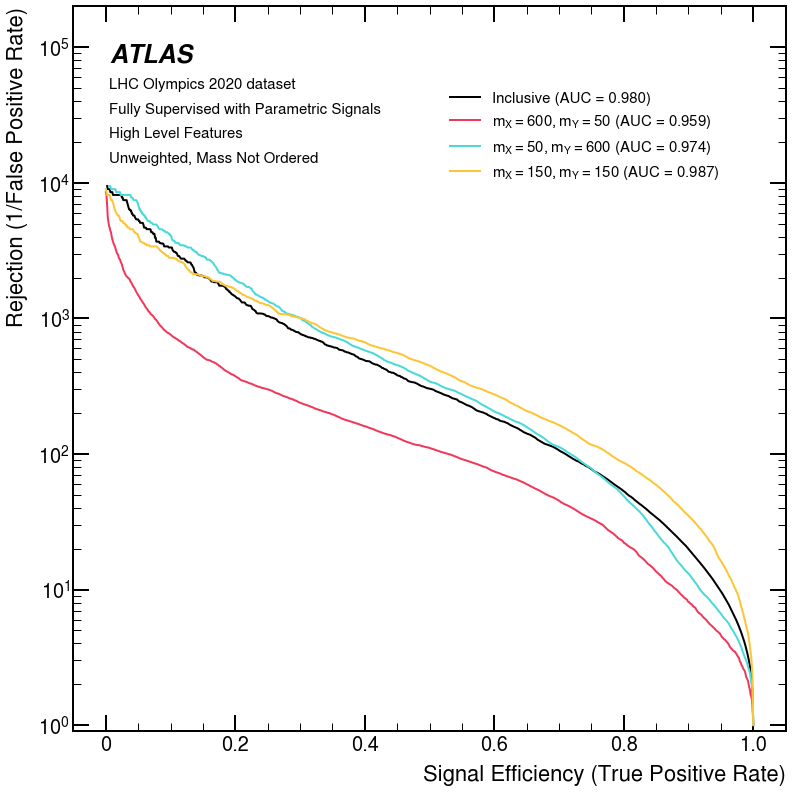

<Figure size 640x480 with 0 Axes>

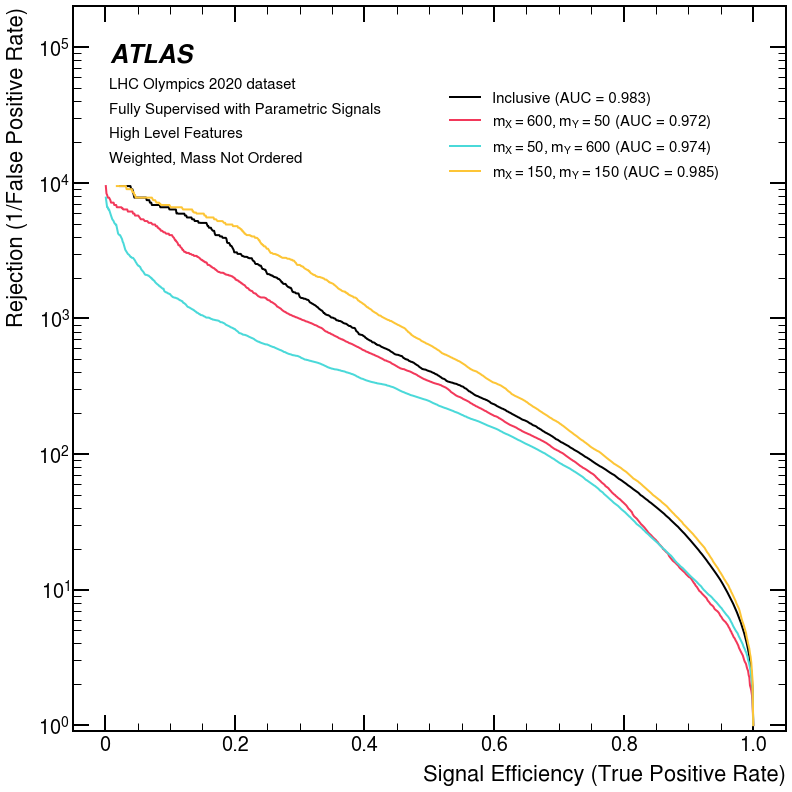

In [28]:
import matplotlib.pyplot as plt
from quickstats.utils.common_utils import combine_dict
from quickstats.plots import General1DPlot
analysis_label_options = {
    'colab': 'ATLAS',
    'status': '', 
    'energy' : None, 
    'lumi' : None,
    'dy': 0.03,
    'dy_main': 0,
    'loc': (0.05, 0.95),
    'extra_text': f'LHC Olympics 2020 dataset//Fully Supervised with Parametric Signals//High Level Features'
}
styles = {
    'figure': {
        'figsize': (11.111, 11.111),
    },
    'legend': {
        'loc': (0.52, 0.75),
        'fontsize': 15
    },
    'text': {
        'fontsize': 15
    }
}
scenario_map = {
    'mass_ordered_weighted': 'Weighted, Mass Ordered',
    'mass_ordered_unweighted': 'Unweighted, Mass Ordered',
    'mass_unordered_weighted': 'Weighted, Mass Not Ordered',
    'mass_unordered_unweighted': 'Unweighted, Mass Not Ordered'
}
for scenario in scenarios:
    dfs = target_mass_dfs[scenario]
    label_map = {}
    for mass_point in dfs:
        roc_auc = aucs[scenario][mass_point]
        if mass_point == 'inclusive':
            label = f'Inclusive'
        else:
            m1, m2 = mass_point.split("_")
            label = f'$m_X={m1}, m_Y={m2}$'
        label += f' (AUC = {roc_auc:.3f})'
        label_map[mass_point] = label
    alo = combine_dict(analysis_label_options)
    alo['extra_text'] += f'//{scenario_map[scenario]}'
    plotter = General1DPlot(dfs, analysis_label_options=alo,
                            color_cycle='default', styles=styles, label_map=label_map)    
    ax = plotter.draw("tpr", "fpr_inv",
                      logy=True,
                      xlabel="Signal Efficiency (True Positive Rate)",
                      ylabel="Rejection (1/False Positive Rate)",
                      ymax=2e5,
                      ymin=0.9)
    plt.show()
    #ax.fill_between(tpr_manual, roc_std[0], roc_std[1], color='rust', alpha=0.3)

<Figure size 640x480 with 0 Axes>

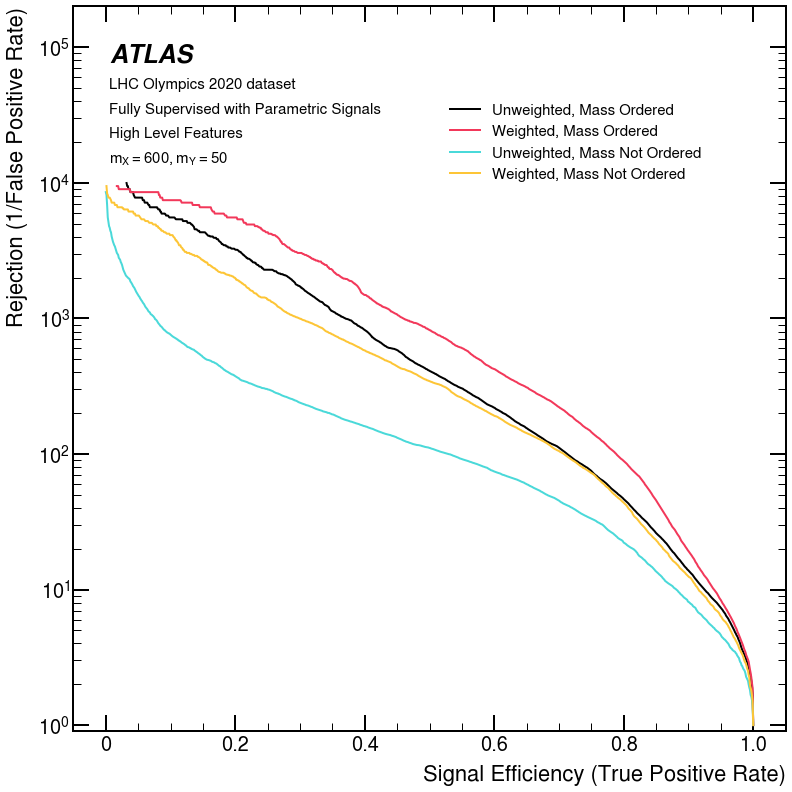

In [29]:
mass_point = '600_50'
dfs = {}
label_map = {}
for scenario in scenarios:
    dfs[scenario] = target_mass_dfs[scenario][mass_point]
    roc_auc = aucs[scenario][mass_point]
    label = scenario_map[scenario]
    label_map[scenario] = label
alo = combine_dict(analysis_label_options)
m1, m2 = mass_point.split("_")
label = f'$m_X={m1}, m_Y={m2}$'
alo['extra_text'] += f'//{label}'
plotter = General1DPlot(dfs, analysis_label_options=alo,
                        color_cycle='default', styles=styles, label_map=label_map)    
ax = plotter.draw("tpr", "fpr_inv",
                  logy=True,
                  xlabel="Signal Efficiency (True Positive Rate)",
                  ylabel="Rejection (1/False Positive Rate)",
                  ymax=2e5,
                  ymin=0.9)
plt.show()